In [1]:
# testing 25 vindr models
# young = 0-5
# old = 6-18
# same train-val-test split is kept, except for test set we are now testing young vs old 
import subprocess
import pandas as pd 
import os
import glob

parent = '/home/jkim/research/peds_cxr/'
gpu = "1"
predefined_seeds = [9,17,18,29,30,34,41,42,51,52,61,66,74,75,78,81,84,86,87,89,90,92,96,98,99]

# batch creating result directiory
for seed in predefined_seeds:
    for dir in ['all', 'young', 'old']:
        # Construct the new directory path for results
        new_result_dir = parent + f"25variation/results/vindr/test/{dir}/vindr_{seed}_{dir}/"
        
        # Create the new directory if it doesn't exist
        if not os.path.exists(new_result_dir):
            os.makedirs(new_result_dir)

for seed in predefined_seeds:
    vindr_metadata_path = parent + '25variation/metadata/final/vindr/vindr_metadata_seed_' + str(seed) + '.csv'
    vindr_metadata = pd.read_csv(vindr_metadata_path)
    
    # Convert 'Patient Age' to integers
    vindr_metadata['Patient Age'] = pd.to_numeric(vindr_metadata['Patient Age'], errors='coerce')

    # Creating vindr_test_young / old .txt
    age_groups = ['young', 'old']
    for age_group in age_groups:
        if age_group == 'young':
            test_index = vindr_metadata[(vindr_metadata['Set'] == 'test') & (vindr_metadata['Patient Age'] >= 0) & (vindr_metadata['Patient Age'] <= 5)]
        else:  # 'old'
            test_index = vindr_metadata[(vindr_metadata['Set'] == 'test') & (vindr_metadata['Patient Age'] >= 6) & (vindr_metadata['Patient Age'] <= 18)]
        
        image_source = parent + '25variation/images/vindr/vindr_' + str(seed) + '/'
        vindr_test_output = image_source + 'vindr_test_'+ age_group +'.txt'
        vindr_test_txt = test_index['Image Index']
        vindr_test_txt.to_csv(vindr_test_output, sep=',', index=False, header=False)


In [2]:
# Testing old vs young
ages = ['young', 'old']
for age in ages:
    for seed in predefined_seeds:
    # Build the pattern to search for model files
        search_pattern = os.path.join(parent, f"25variation/results/vindr/train/vindr_{seed}/DenseNet121_lr0.01_bs16_optSGD_wd0.0_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0_*_model.pt")
        # Use glob to find the file
        matching_files = glob.glob(search_pattern)
        
        # Check if any matching files are found
        if not matching_files:
            print(f"No matching model files found for seed {seed}.")
            continue  # Skip to the next iteration

        # Assuming there's only one matching file, take the first one
        model_file_path = matching_files[0]

        image_source = parent + f'25variation/images/vindr/vindr_{seed}/' 
        command = [
            "python3",
            parent + "transformer-radiographs/test_cxr.py",
            "--cfg-dir", parent + f"25variation/images/vindr/vindr_{seed}/cfg_vindr_{seed}.json",
            "--dataset", f'vindr_{seed}',
            "--labels-set", "labels",
            "--model-state", model_file_path,
            "--model-type", "DenseNet121",
            "--results-dir", parent + f"25variation/results/vindr/test/{age}/vindr_{seed}_{age}",
            "--test-file", image_source + "vindr_test_" + age + ".txt",
            "--use-gpus", gpu
    ]

        # Run the command
        try:
            subprocess.run(command, check=True)
        except subprocess.CalledProcessError as e:
            print(f"An error occurred while executing the command: {e}")


Test set: starting load
Using image path file
Using no transforms
Loaded 1478 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_9_DenseNet121_vindr_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1478 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_17_DenseNet121_vindr_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1478 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_18_DenseNet121_vindr_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1478 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_29_DenseNet121_vindr_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1478 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_30_DenseNet121_vindr_test_young'])

Test set: starting load
Using image path file
Using no transforms
Loaded 1478 images
Device: cuda #: 1 #cpus: 128

dict_keys(['vindr_34_DenseNet121_vindr_t

In [3]:
import pickle
import pandas as pd
import os 
import glob

# setting directories
ages = ['young', 'old']
age_file_name = ['_young', '_old']

for age, age_name in zip(ages, age_file_name):
    for seed in predefined_seeds:
        # Build the pattern to search for model files
            search_pattern = os.path.join(parent, f"25variation/results/vindr/test/{age}/vindr_{seed}_{age}/DenseNet121_lr0.01_bs16_optSGD_wd0.0_sch_step_pp3_bp5_trtrain.txt_vaval.txt_tfpeds_nlbatch_do0.0_*.pkl")
        
            # Use glob to find the file
            matching_files = glob.glob(search_pattern)
            
            # Check if any matching files are found
            if not matching_files:
                print(f"No matching model files found for seed {seed}.")
                continue  # Skip to the next iteration

            pkl_directory = matching_files[0]

            directory = parent + f'25variation/results/vindr/unpickle/{age}/'
            if not os.path.exists(directory):
                os.makedirs(directory)

            # Open the pickle file and load the data
            with open(pkl_directory, "rb") as f:
                data = pickle.load(f)

            # Extract the nested dictionary
            nested_dict = data.get(f'vindr_{seed}_DenseNet121_vindr_test{age_name}', {})

            # Create a DataFrame from the nested dictionary with keys 'y', 'yhat', and 'file'
            df_nested = pd.DataFrame({
                "y": nested_dict["y"],
                "yhat": nested_dict["yhat"],
                "file": nested_dict["file"]
            })

            # Define the file path
            nested_file_path = directory + f'vindr_{seed}_{age}_pkl.csv'

            # Save the DataFrame to a CSV file
            df_nested.to_csv(nested_file_path, index=False)


In [4]:
# Saving Pkl file as csv file 

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
import ast
import os
import matplotlib.pyplot as plt

# create AUC directory in results
if not os.path.exists(parent + '25variation/results/vindr/analysis/plot/age'):
    os.makedirs(parent + '25variation/results/vindr/analysis/plot/age')
for age in ages: 
    if not os.path.exists(parent + f'25variation/results/vindr/analysis/unpickledcsv/{age}'):
        os.makedirs(parent + f'25variation/results/vindr/analysis/unpickledcsv/{age}')  

for seed in predefined_seeds:        
    for age in ages: 
        # set directories
        pkl_dir = parent + f'25variation/results/vindr/unpickle/{age}/vindr_{seed}_{age}_pkl.csv'

        # Loading the pkl file
        vindr_pkl = pd.read_csv(pkl_dir)

        # Defining the vindr_label as the list of labels
        vindr_label = ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]

        # Converting the string representation of lists to actual lists
        vindr_pkl['y'] = vindr_pkl['y'].apply(ast.literal_eval)
        vindr_pkl['yhat'] = vindr_pkl['yhat'].apply(ast.literal_eval)

        # Splitting the one-hot encoded labels and predictions into separate columns
        y_true_df = pd.DataFrame(vindr_pkl['y'].tolist(), columns=vindr_label)
        y_pred_df = pd.DataFrame(vindr_pkl['yhat'].tolist(), columns=vindr_label)

        # Merging the true labels and predicted probabilities based on index
        result_df = pd.concat([y_true_df, y_pred_df.add_suffix('_pred')], axis=1)

        # Saving
        result_df.to_csv(parent + f'25variation/results/vindr/analysis/unpickledcsv/{age}/vindr_{seed}_{age}_pkl.csv', index=False)


In [5]:
# Old and Young performance comparison
# pneumothorax is dropped in age analysis since no pneumothorax dx is found in young population. 
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from scipy.stats import ttest_ind, t
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import sem
from scipy.stats import ttest_ind
import pandas as pd
import os

# List of seeds and labels
labels = ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]

# Initialize the dictionary to hold universal thresholds for each label
universal_thresholds = {label: {} for label in labels}

# Base file paths for old and young CSV files
base_file_path_old = parent + "25variation/results/vindr/analysis/unpickledcsv/old/vindr_{seed}_old_pkl.csv"
base_file_path_young = parent + "25variation/results/vindr/analysis/unpickledcsv/young/vindr_{seed}_young_pkl.csv"

# Loop through all seeds
for seed in predefined_seeds:
    file_path = os.path.join(parent, f"25variation/results/vindr/analysis/unpickledcsv/all/vindr_{seed}_all_pkl.csv")
    df = pd.read_csv(file_path)
    
    for label in labels:
        true_labels = df[f'{label}']
        predicted_scores = df[f'{label}_pred']
        
        # Calculate ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(true_labels, predicted_scores)
                
        # Calculating Youden's Index to find the optimal threshold
        youden_index = tpr + (1 - fpr) - 1
        optimal_idx = np.argmax(youden_index)
        optimal_threshold = thresholds[optimal_idx]
        
        # Store this optimal threshold for this label and seed
        universal_thresholds[label][seed] = optimal_threshold

def calculate_metrics_and_auroc(df, label, optimal_threshold):
    true_labels = df[label]
    predicted_scores = df[f"{label}_pred"]

    auroc = np.nan
    sensitivity = np.nan
    specificity = np.nan
    ppv = np.nan
    npv = np.nan
    f1_score = np.nan
    fpr = np.nan
    fnr = np.nan
    try:
        # Calculate AUROC
        auroc = roc_auc_score(true_labels, predicted_scores)
    except ValueError:
        # If error occurs, you can print a message or pass
        print(f"Only one class present in {label}. Setting AUROC to NaN.")
    
    predicted_labels = (predicted_scores >= optimal_threshold).astype(int)

    try:
        tn, fp, fn, tp = confusion_matrix(true_labels, predicted_labels).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) != 0 else 0
        npv = tn / (tn + fn) if (tn + fn) != 0 else 0
        f1_score = 2 * (ppv * sensitivity) / (ppv + sensitivity) if (ppv + sensitivity) != 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) != 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) != 0 else 0
    except ValueError:
        print(f"Error calculating confusion matrix for {label}. Metrics set to NaN.")

    return [auroc, sensitivity, specificity, ppv, npv, f1_score, fpr, fnr, optimal_threshold]

# Initialize empty DataFrames for storing metrics
cols = ['Seed', 'Label', 'AUROC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1 Score', 'FPR', 'FNR', 'Youden_Threshold'] 
metrics_old_df = pd.DataFrame(columns=cols)
metrics_young_df = pd.DataFrame(columns=cols)

# Loop through all seeds
for seed in predefined_seeds:
    df_old = pd.read_csv(base_file_path_old.format(seed=seed))
    df_young = pd.read_csv(base_file_path_young.format(seed=seed))
    
    metrics_old_all_label = []
    metrics_young_all_label = []
    
    for label in labels:
        optimal_threshold = universal_thresholds[label][seed]
        
        # Calculate metrics for old and young
        metrics_old = calculate_metrics_and_auroc(df_old, label, optimal_threshold)
        metrics_young = calculate_metrics_and_auroc(df_young, label, optimal_threshold)
        
        # Store metrics for "All Label" calculation
        metrics_old_all_label.append(metrics_old)
        metrics_young_all_label.append(metrics_young)

        # Append to DataFrame
        metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
        metrics_young_df = metrics_young_df.append(pd.Series([seed, label] + metrics_young, index=cols), ignore_index=True)
    
    # Calculate and append the "All Label" row
    metrics_old_average = np.mean(metrics_old_all_label, axis=0).tolist()
    metrics_young_average = np.mean(metrics_young_all_label, axis=0).tolist()
    
    metrics_old_df = metrics_old_df.append(pd.Series([seed, "All Label"] + metrics_old_average, index=cols), ignore_index=True)
    metrics_young_df = metrics_young_df.append(pd.Series([seed, "All Label"] + metrics_young_average, index=cols), ignore_index=True)

# Save the metrics DataFrames to CSV
metrics_old_df.to_csv(parent + "25variation/results/vindr/analysis/csv/metrics_old_all.csv", index=False)
metrics_young_df.to_csv(parent + "25variation/results/vindr/analysis/csv/metrics_young_all.csv", index=False)


/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_young_df = metrics_young_df.append(pd.Series([seed, label] + metrics_young, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.


/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_young_df = metrics_young_df.append(pd.Series([seed, label] + metrics_young, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Only one class present in Cardiomegaly. Setting AUROC to NaN.
Error calculating confusion matrix for Cardiomegaly. Metrics set to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Error calculating confusion matrix for Cardiomegaly. Metrics set to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.


/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_young_df = metrics_young_df.append(pd.Series([seed, label] + metrics_young, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.


/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_young_df = metrics_young_df.append(pd.Series([seed, label] + metrics_young, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Error calculating confusion matrix for Cardiomegaly. Metrics set to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.


/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_young_df = metrics_young_df.append(pd.Series([seed, label] + metrics_young, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.
Only one class present in Cardiomegaly. Setting AUROC to NaN.


/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_young_df = metrics_young_df.append(pd.Series([seed, label] + metrics_young, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:104: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_old_df = metrics_old_df.append(pd.Series([seed, label] + metrics_old, index=cols), ignore_index=True)
/tmp/ipykernel_4154683/2686445576.py:105: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a f

In [6]:
## Statistical analysis old vs young -> average, CI, and T-test, creation of vindr_MF_stats.csv

import pandas as pd
import numpy as np
from scipy.stats import ttest_rel, t
from statsmodels.stats.multitest import multipletests

# Define paths and labels
labels = ["All Label", "No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]

# Load the CSV files
df_metrics_old = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_old_all.csv")
df_metrics_young = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_young_all.csv")
df_metrics_all = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_all_all.csv")

# Function to calculate the mean and 95% CI for a given metric and label
def calc_mean_and_ci(metric_values):
    mean_value = np.mean(metric_values)
    stderr = np.std(metric_values, ddof=1) / np.sqrt(len(metric_values))
    ci = stderr * t.ppf((1 + 0.95) / 2., len(metric_values) - 1)
    return mean_value, (mean_value - ci, mean_value + ci)

# List of metrics to analyze
metrics_to_analyze = ['AUROC', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'F1 Score', 'FPR', 'FNR']

# Collect p-values for later adjustment
p_values = []
comparison_labels = []  # Keep track of comparisons for assigning corrected p-values

# check if lengths match before running ttest_rel
for metric in metrics_to_analyze:
    for label in labels:
        metric_values_old = df_metrics_old[df_metrics_old['Label'] == label][metric].dropna()
        metric_values_young = df_metrics_young[df_metrics_young['Label'] == label][metric].dropna()
        
        # Only proceed if lengths are equal
        if len(metric_values_old) == len(metric_values_young) and len(metric_values_old) > 0:
            _, p_value = ttest_rel(metric_values_old, metric_values_young)
            p_values.append(p_value)
            comparison_labels.append((metric, label))
        else:
            print(f"Skipping t-test for {label} and {metric} due to unequal array lengths.")

# Apply the Benjamini-Hochberg correction
_, pvals_corrected, _, _ = multipletests(p_values, alpha=0.05, method='fdr_bh')

# Initialize empty DataFrame for storing summary stats
summary_cols = ['Metric', 'Label', 'Mean_All', 'CI_All', 'Mean_young', 'CI_young', 'Mean_old', 'CI_old', 'p_value_before_BH', 'p_value_after_BH']
stats_df = pd.DataFrame(columns=summary_cols)

# Fill in the DataFrame with means, CIs, and both sets of p-values
for i, (metric, label) in enumerate(comparison_labels):
    metric_values_old = df_metrics_old[df_metrics_old['Label'] == label][metric].dropna()
    metric_values_young = df_metrics_young[df_metrics_young['Label'] == label][metric].dropna()
    metric_values_all = df_metrics_all[df_metrics_all['Label'] == label][metric].dropna()

    mean_old, ci_old = calc_mean_and_ci(metric_values_old)
    mean_young, ci_young = calc_mean_and_ci(metric_values_young)
    mean_all, ci_all = calc_mean_and_ci(metric_values_all)

    stats_df = stats_df.append({
        'Metric': metric,
        'Label': label,
        'Mean_All': mean_all,
        'CI_All': ci_all,
        'Mean_young': mean_young,
        'CI_young': ci_young,
        'Mean_old': mean_old,
        'CI_old': ci_old,
        'p_value_before_BH': p_values[i],
        'p_value_after_BH': pvals_corrected[i]
    }, ignore_index=True)

# Calculate clinical significance based on the absolute percentage difference
stats_df['abs_percent_diff'] = abs((stats_df['Mean_old'] - stats_df['Mean_young']) / stats_df['Mean_old']) * 100
stats_df['clinical_significance_1%'] = (stats_df['abs_percent_diff'] > 1).astype(int)
stats_df['clinical_significance_3%'] = (stats_df['abs_percent_diff'] > 3).astype(int)
stats_df['clinical_significance_5%'] = (stats_df['abs_percent_diff'] > 5).astype(int)

# Save the summary DataFrame to CSV
stats_df.to_csv(parent + "25variation/results/vindr/analysis/csv/vindr_age_stats.csv", index=False)


/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat

Skipping t-test for All Label and AUROC due to unequal array lengths.
Skipping t-test for Cardiomegaly and AUROC due to unequal array lengths.
Skipping t-test for All Label and Sensitivity due to unequal array lengths.
Skipping t-test for Cardiomegaly and Sensitivity due to unequal array lengths.
Skipping t-test for All Label and Specificity due to unequal array lengths.
Skipping t-test for Cardiomegaly and Specificity due to unequal array lengths.
Skipping t-test for All Label and PPV due to unequal array lengths.
Skipping t-test for Cardiomegaly and PPV due to unequal array lengths.
Skipping t-test for All Label and NPV due to unequal array lengths.
Skipping t-test for Cardiomegaly and NPV due to unequal array lengths.
Skipping t-test for All Label and F1 Score due to unequal array lengths.
Skipping t-test for Cardiomegaly and F1 Score due to unequal array lengths.
Skipping t-test for All Label and FPR due to unequal array lengths.
Skipping t-test for Cardiomegaly and FPR due to uneq

/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stats_df = stats_df.append({
/tmp/ipykernel_4154683/2542559088.py:61: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  stat

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:1.074e-11
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:8.173e-09
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:2.335e-05
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:2.249e-14
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:5.762e-04


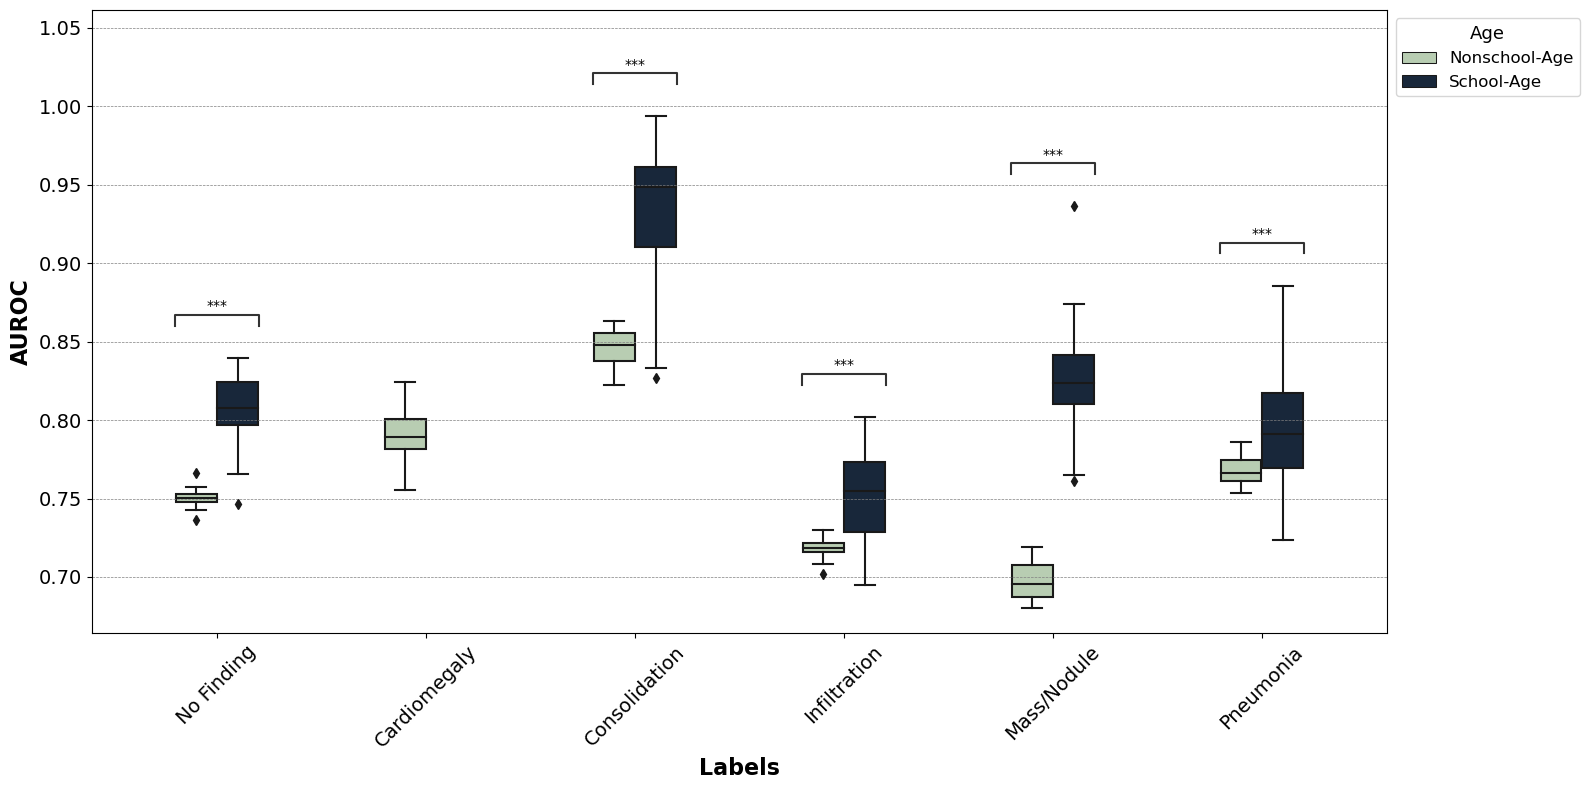

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:5.681e-20
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:7.420e-01
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:1.130e-17
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:3.114e-01
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:7.720e-02


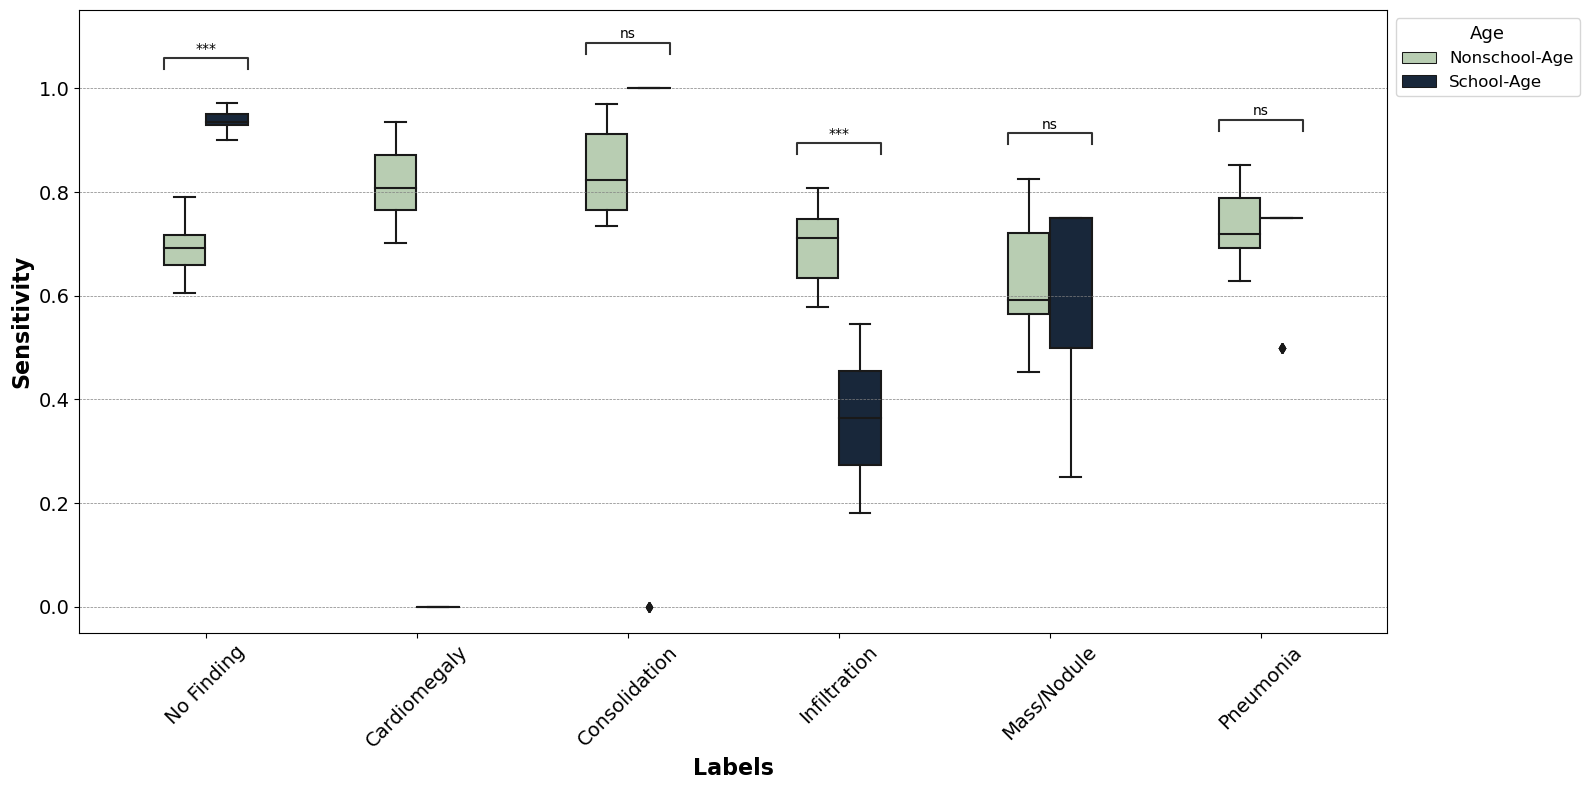

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:1.561e-16
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:3.389e-16
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:1.130e-17
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:5.814e-15
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:3.650e-17


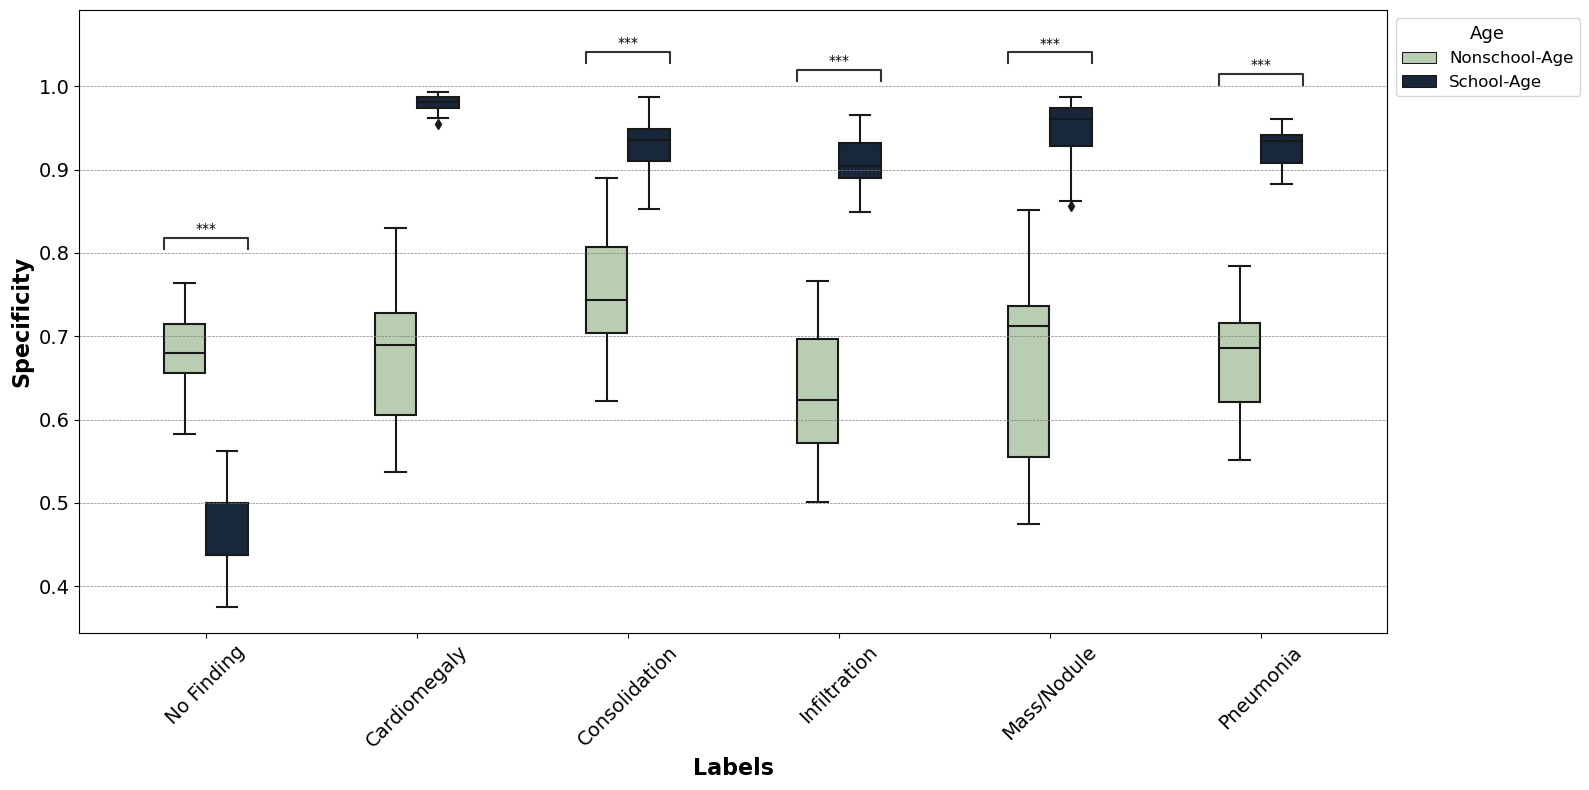

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:1.224e-26
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:9.367e-01
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:4.308e-10
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:1.777e-05
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:4.076e-02


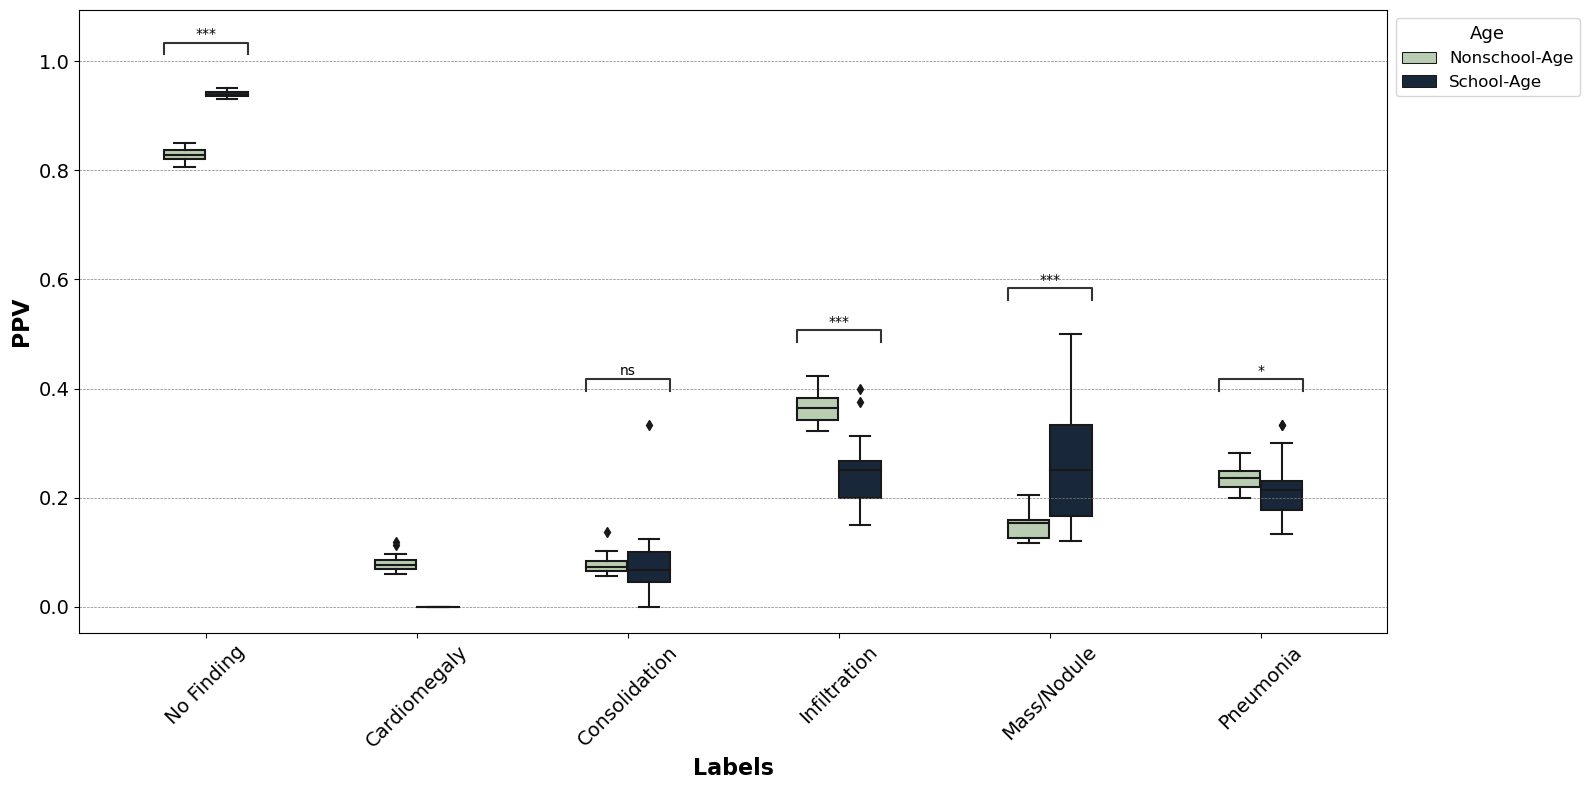

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:7.160e-02
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:3.094e-06
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:2.047e-21
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:1.446e-19
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:1.639e-18


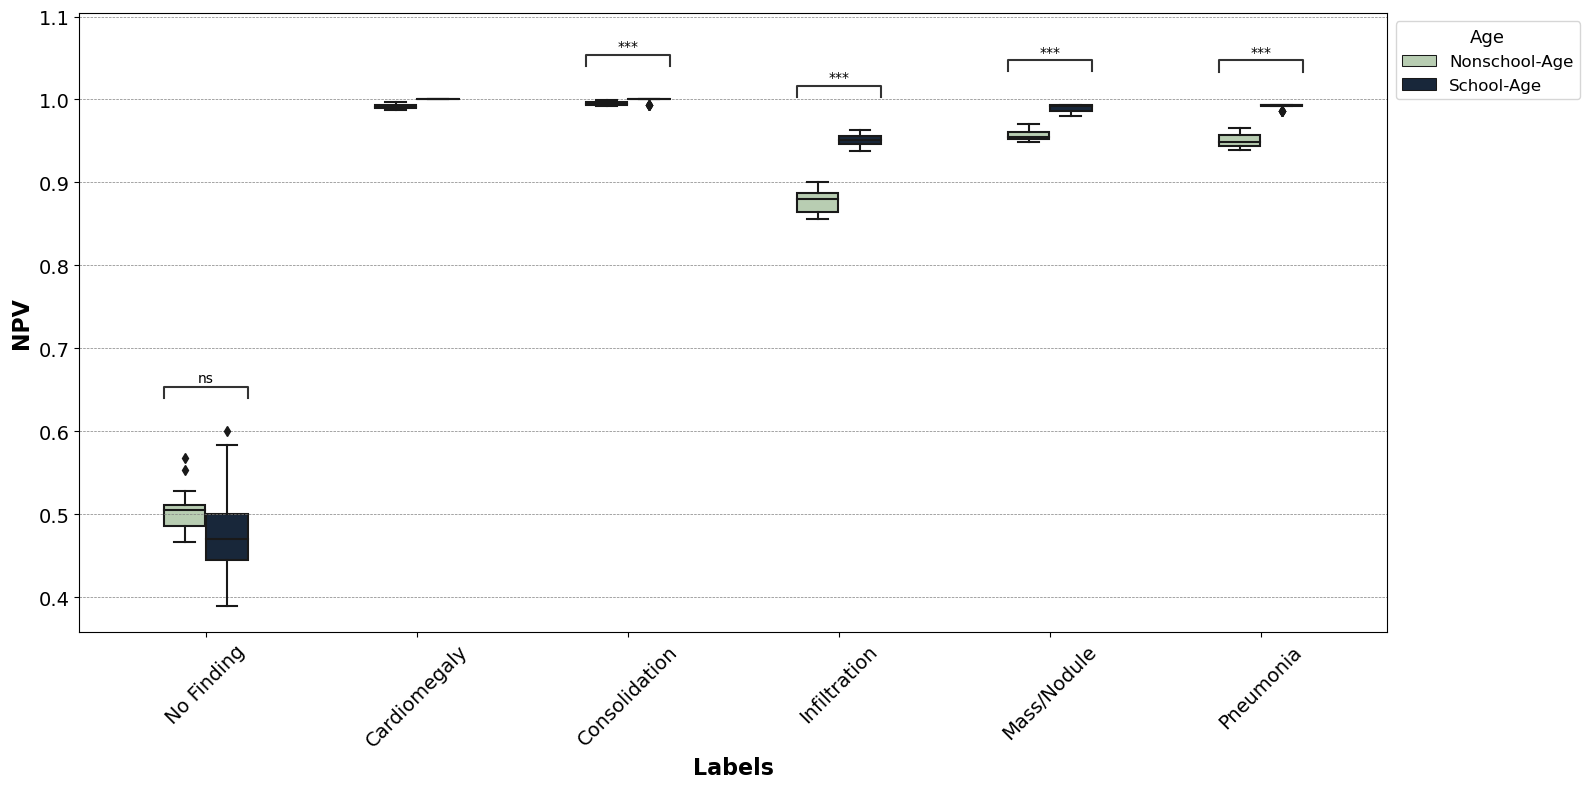

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:2.315e-22
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:8.332e-01
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:2.934e-14
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:8.314e-05
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:2.066e-02


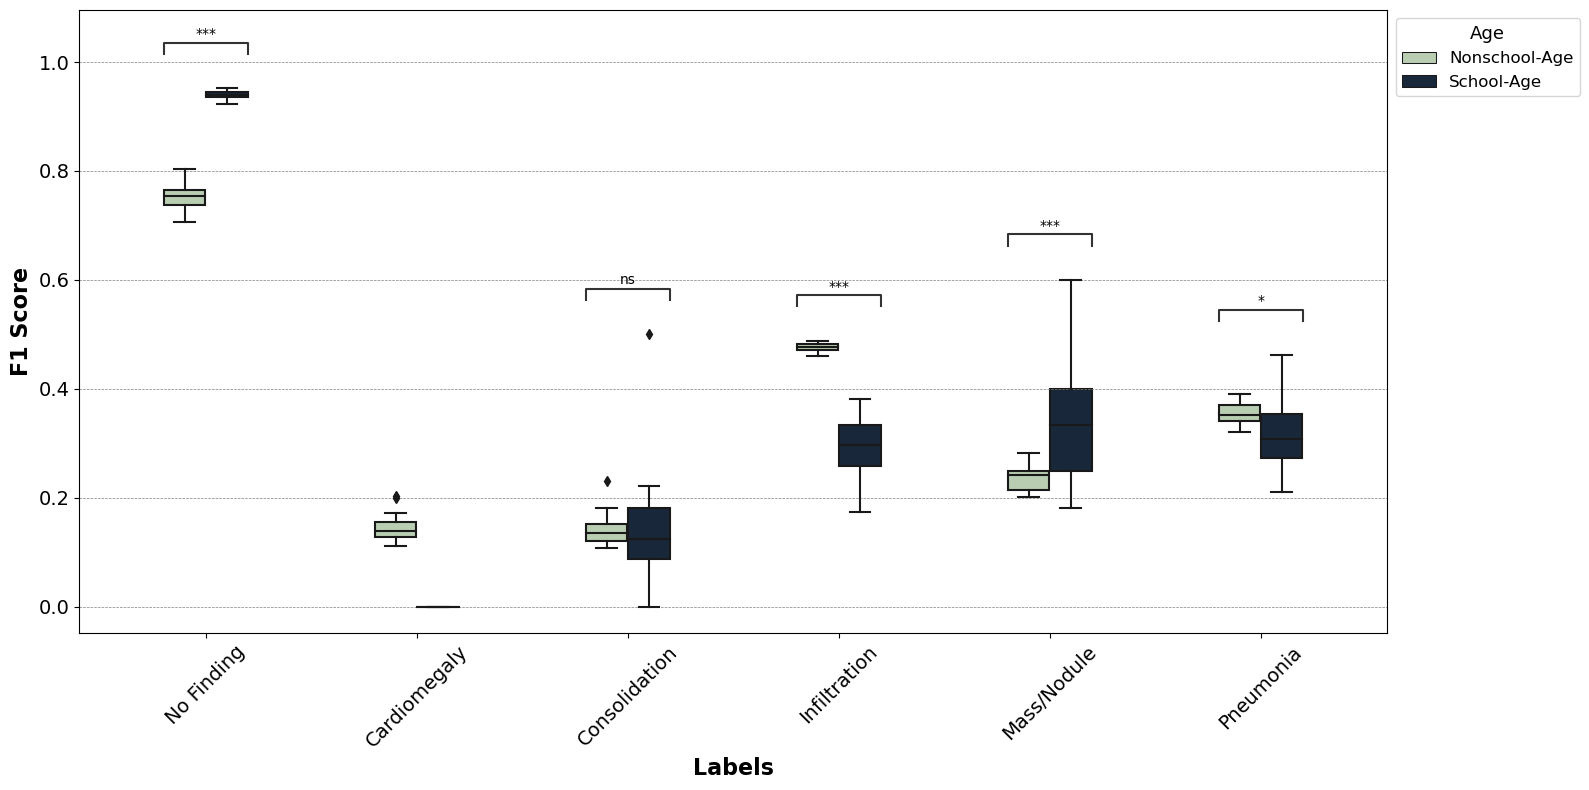

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:1.561e-16
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:3.389e-16
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:1.130e-17
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:5.814e-15
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:3.650e-17


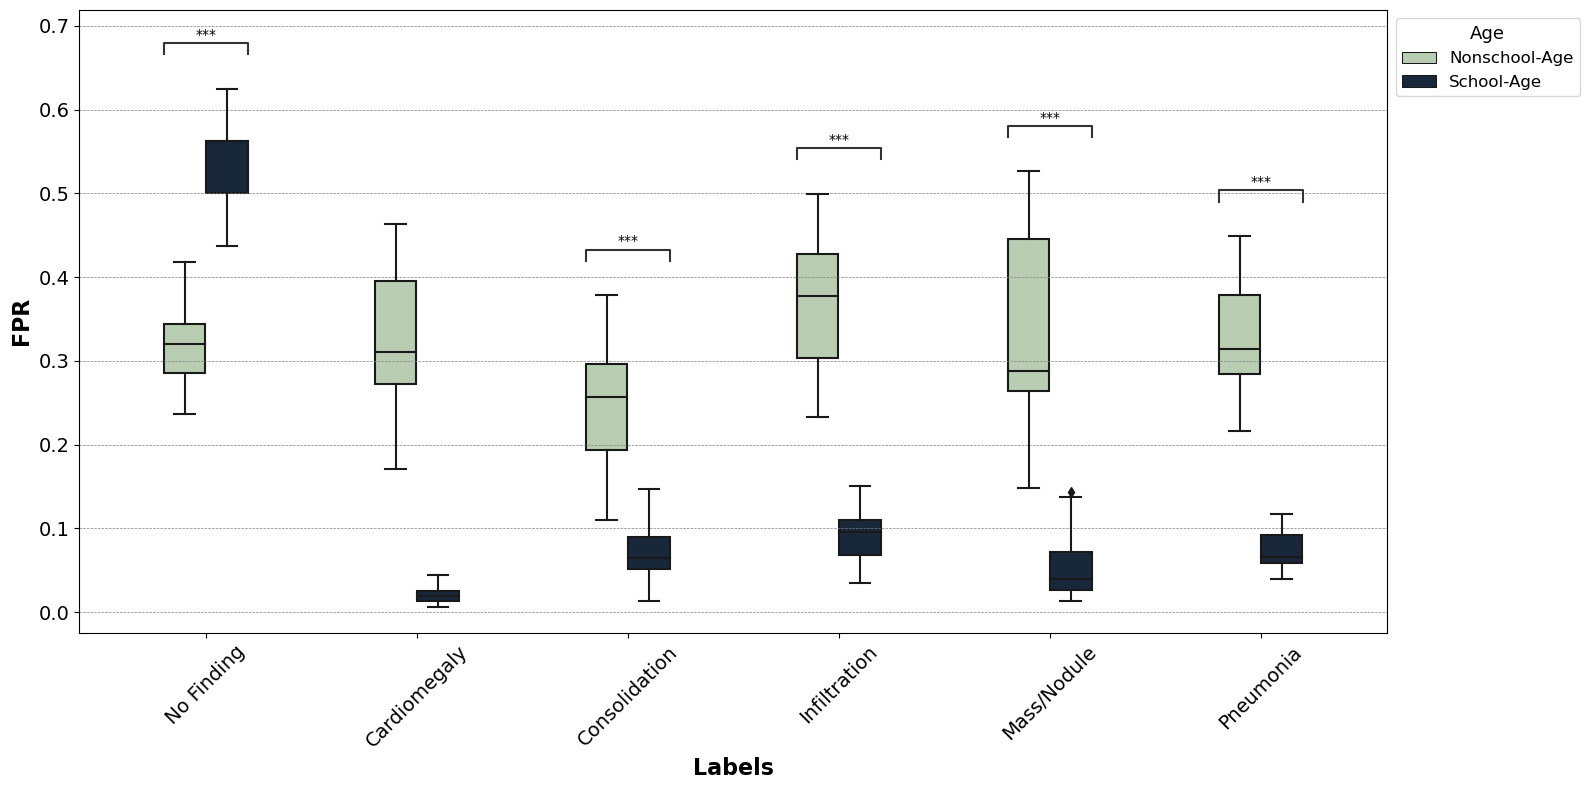

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: p <= 1.00e-03

No Finding_Nonschool-Age v.s. No Finding_School-Age: Custom statistical test, P_val:5.681e-20
Consolidation_Nonschool-Age v.s. Consolidation_School-Age: Custom statistical test, P_val:7.420e-01
Infiltration_Nonschool-Age v.s. Infiltration_School-Age: Custom statistical test, P_val:1.130e-17
Mass/Nodule_Nonschool-Age v.s. Mass/Nodule_School-Age: Custom statistical test, P_val:3.114e-01
Pneumonia_Nonschool-Age v.s. Pneumonia_School-Age: Custom statistical test, P_val:7.720e-02


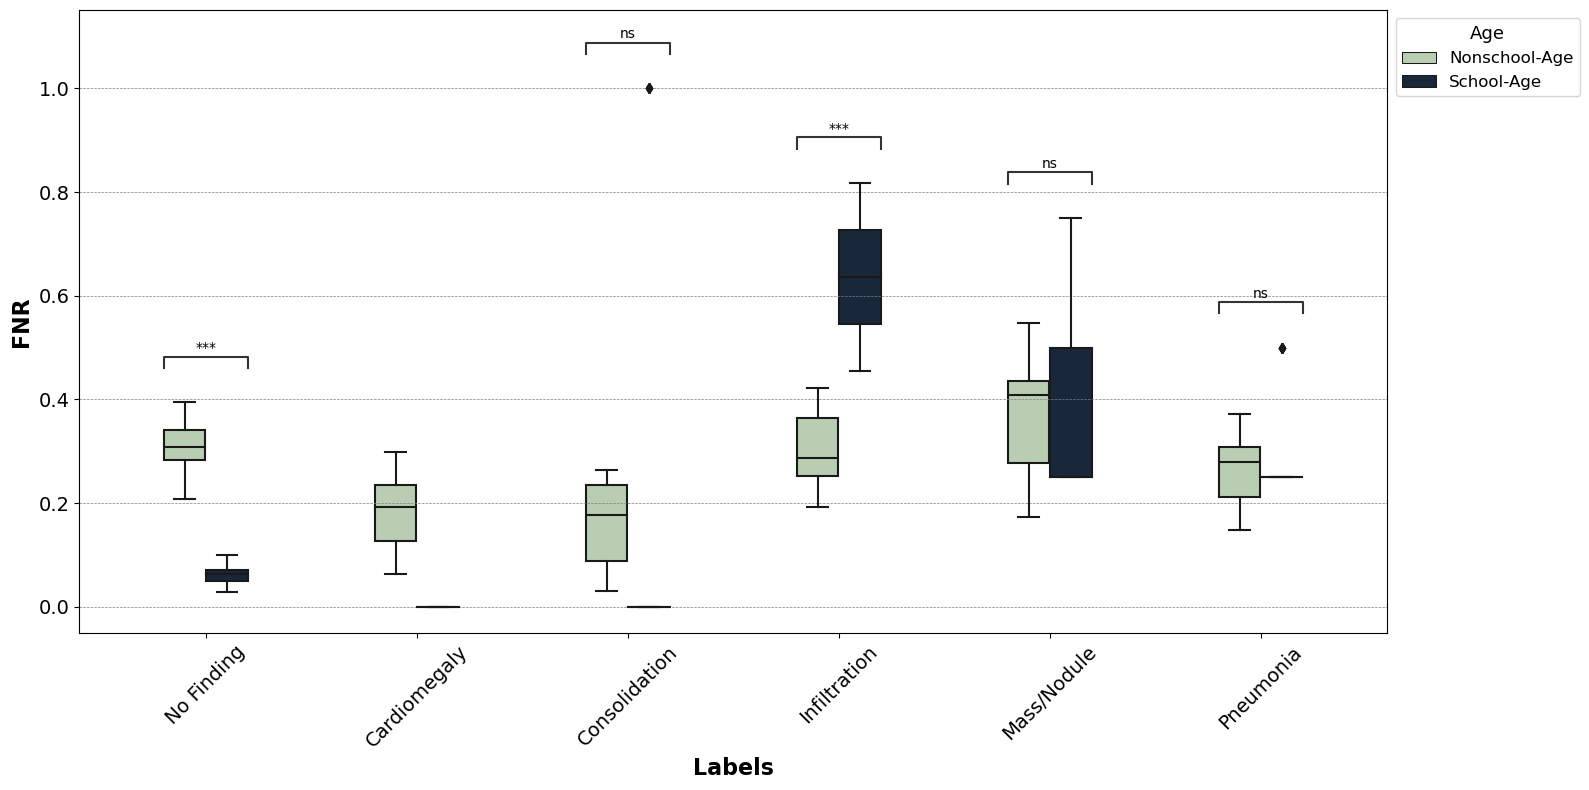

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statannot import add_stat_annotation

parent = '/home/jkim/research/peds_cxr/'

# Define paths and read the CSV files
vindr_age_stats = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/vindr_age_stats.csv")
metrics_young_all = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_young_all.csv")
metrics_old_all = pd.read_csv(parent + "25variation/results/vindr/analysis/csv/metrics_old_all.csv")

# Add sex column to metrics dataframes and combine them
metrics_young_all['Age'] = 'Nonschool-Age'
metrics_old_all['Age'] = 'School-Age'
combined_metrics = pd.concat([metrics_young_all, metrics_old_all])

# Extract unique metrics and labels
unique_metrics = vindr_age_stats['Metric'].unique()
unique_labels = ["No Finding", "Cardiomegaly", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]
pvalue_pairs = ["No Finding", "Consolidation", "Infiltration", "Mass/Nodule", "Pneumonia"]
neutral_palette = ["#b5d1ae", "#122740"]

for metric in unique_metrics:
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.boxplot(x='Label', y=metric, hue='Age', data=combined_metrics, ax=ax, order=unique_labels, palette=neutral_palette, width=0.4)
    
    # Other plot adjustments
    ax.set_xlabel('Labels', fontsize=16, fontweight='bold')
    ax.set_ylabel(metric, fontsize=16, fontweight='bold')
    ax.tick_params(axis='x', labelsize=14, rotation=45)
    ax.tick_params(axis='y', labelsize=14)
    ax.grid(True, linestyle='--', linewidth=0.5, color='gray', axis='y')

    # Prepare a list of tuples for box_pairs
    box_pairs = [((label, 'Nonschool-Age'),(label, 'School-Age')) for label in pvalue_pairs]
    
    # Extract p-values for each label and metric combination
    p_values = [vindr_age_stats[(vindr_age_stats['Metric'] == metric) & 
                                    (vindr_age_stats['Label'] == label)]['p_value_after_BH'].values[0] 
                for label in pvalue_pairs]
    
    # Add statistical annotation
    add_stat_annotation(ax, data=combined_metrics, x='Label', y=metric, hue='Age',
                        box_pairs=box_pairs, perform_stat_test=False, pvalues=p_values, 
                        test_short_name='Custom', loc='inside', verbose=2, 
                        pvalue_thresholds=[(0.001, '***'), (0.01, '**'), (0.05, '*'), (1, 'ns')])
    
    ax.legend(title='Age', title_fontsize='13', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))

    # Save the plot
    plt.tight_layout()
    plot_file_path = parent + f'25variation/results/vindr/analysis/plot/age/{metric}_comparison.jpeg'
    plt.savefig(plot_file_path, format='jpeg')
    plt.show()
    plt.close(fig)
